In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pathlib

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from Bio import SeqIO
from torch import Tensor

from src.data_models.models import DnaRepresentation
from src.preprocessing.sequence_representations import (
    NucleotideMappingMethod,
    SequenceRepresentationFactory,
)
from src.preprocessing.utils import min_max_scale_globally, pad_array
from src.utils.factories import get_transformation_function

In [3]:
def read_dna_data_from_file(file_path: str) -> tuple[list[str], list[int]]:
    sequences: list[str] = []
    classes: list[int] = []

    with open(file_path, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            seq_str: str = str(record.seq)
            # The class is the last character in the sequence
            class_label: int = int(seq_str[-1])
            dna_sequence: str = seq_str[:-1]

            sequences.append(dna_sequence)
            classes.append(class_label)

    return sequences, classes

In [4]:
sequences, classes = [], []

for file_path in pathlib.Path("../../data/classification").glob("*.txt"):
    file_sequences, file_classes = read_dna_data_from_file(file_path)
    sequences.extend(file_sequences)
    classes.extend(file_classes)
    break

In [5]:
df = pd.DataFrame({"sequences": sequences, "classes": classes})

In [6]:
df.shape

(14601, 2)

In [7]:
df.head()

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
3,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
4,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0


In [8]:
df["sequences"].map(len).describe()

count    14601.000000
mean       499.983494
std          1.628030
min        310.000000
25%        500.000000
50%        500.000000
75%        500.000000
max        500.000000
Name: sequences, dtype: float64

In [9]:
sequences_len_diff_500 = df[df["sequences"].map(len) != 500]

In [10]:
sequences_len_diff_500.head(2)

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
263,TTATATTTGTTTAAATTGGATTTGTTTACATTAGATTTGTTTACAT...,0


<Axes: xlabel='classes', ylabel='count'>

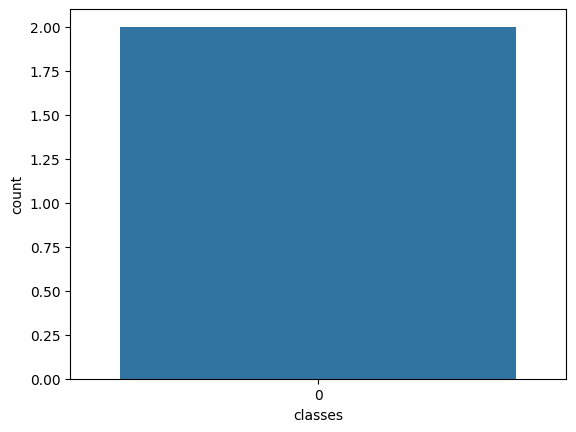

In [11]:
sns.countplot(x=sequences_len_diff_500["classes"])

We will drop the sequences with length different from 500

In [12]:
df.shape

(14601, 2)

In [13]:
len(sequences_len_diff_500.index)

2

In [14]:
df.drop(sequences_len_diff_500.index, inplace=True)
df.reset_index(inplace=True, drop=True)

In [15]:
(df["sequences"].map(len) != 500).sum()

0

The distribution of the labels

<Axes: xlabel='classes', ylabel='count'>

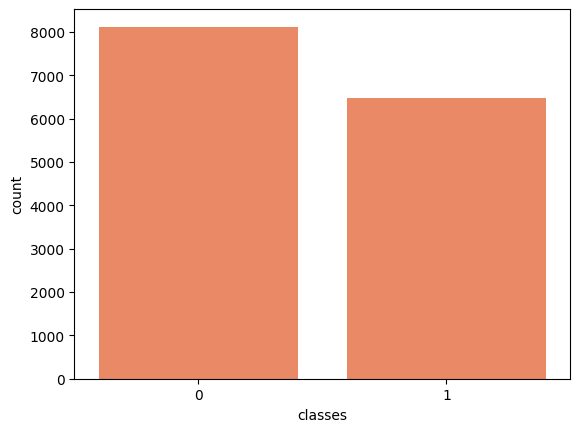

In [16]:
sns.countplot(x=df["classes"], color="coral")

In [17]:
sampled_df = df.groupby("classes", group_keys=False).apply(
    lambda x: x.sample(100, random_state=312)
)

/tmp/ipykernel_10834/2569573567.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("classes", group_keys=False).apply(


In [18]:
# Rudimentary
rudimentary_df_sample = sampled_df.copy()
rudimentary_df_sample["sequences"] = rudimentary_df_sample["sequences"].map(
    get_transformation_function(DnaRepresentation.rudimentary)
)

# Refined
refined_df_sample = sampled_df.copy()
refined_df_sample["sequences"] = refined_df_sample["sequences"].map(
    get_transformation_function(DnaRepresentation.refined)
)


huffman_df_sample = sampled_df.copy()
huffman_df_sample["sequences"] = huffman_df_sample["sequences"].map(
    get_transformation_function(DnaRepresentation.huffman)
)

In [19]:
CLASS_COLORS = {0: "orange", 1: "green"}


def plot_sequence(row, ax):
    sequence = row["sequences"]
    class_label = row["classes"]
    x, y = zip(*sequence)
    color = CLASS_COLORS[class_label]
    ax.plot(x, y, color=color, linestyle="-", marker="o", markersize=0.7)


def create_legend_handle(class_label):
    color = CLASS_COLORS[class_label]
    return mlines.Line2D(
        [],
        [],
        color=color,
        marker="o",
        linestyle="None",
        markersize=10,
        label=f"Class {class_label}",
    )


def plot_sequences(df: pd.DataFrame, plot_title: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    for index, row in df.iterrows():
        plot_sequence(row, ax)

    legend_handles = [create_legend_handle(label) for label in CLASS_COLORS.keys()]
    ax.legend(handles=legend_handles)

    plt.title(plot_title)
    plt.show()

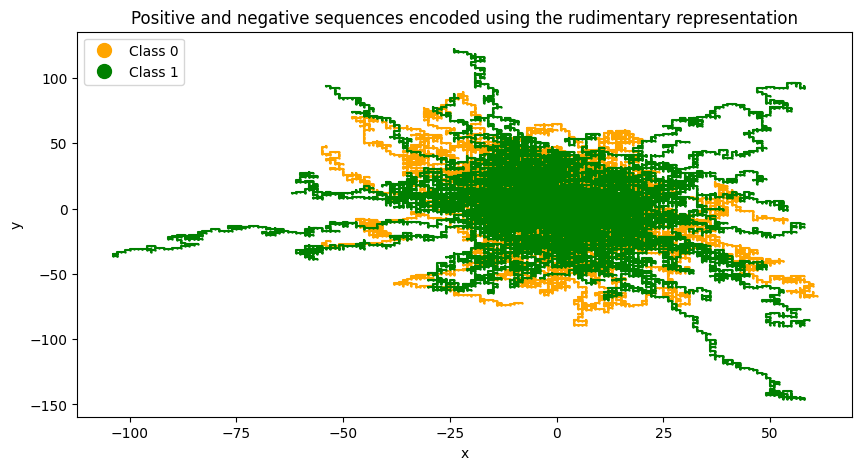

In [20]:
plot_sequences(
    rudimentary_df_sample,
    "Positive and negative sequences encoded using the rudimentary representation",
)

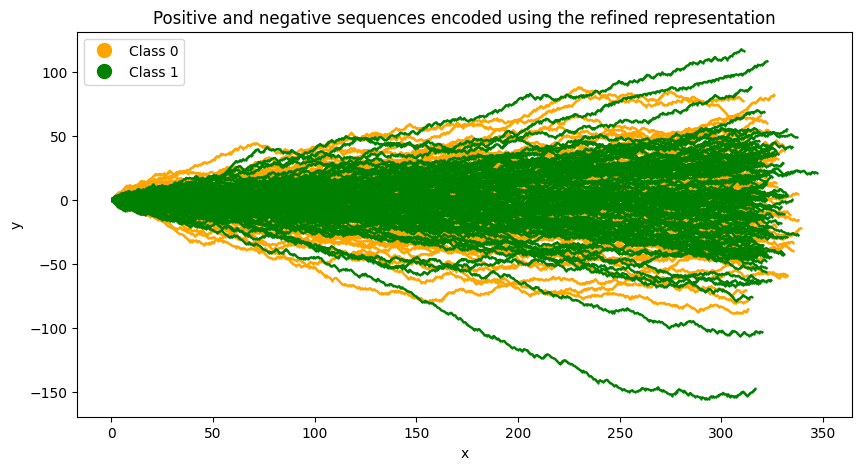

In [21]:
plot_sequences(
    refined_df_sample,
    "Positive and negative sequences encoded using the refined representation",
)

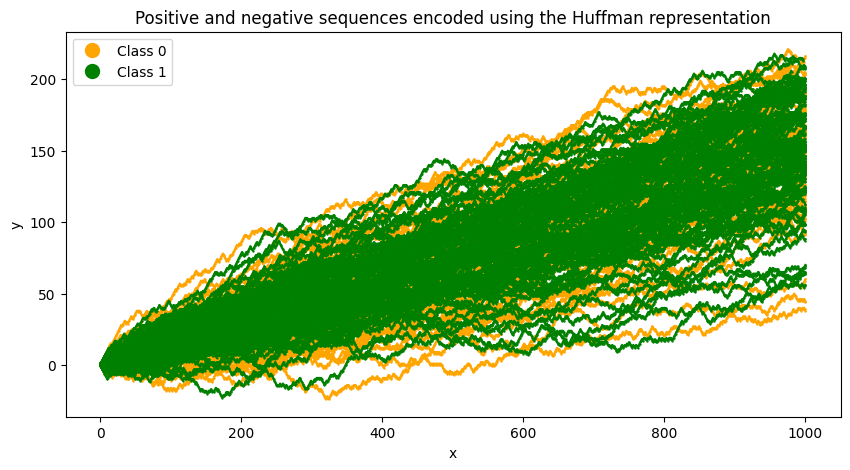

In [22]:
plot_sequences(
    huffman_df_sample,
    "Positive and negative sequences encoded using the Huffman representation",
)

# Scaling & Padding

## Refined Representation

- Apply transformation function
- Scale
- Restructure as a tensor

In [23]:
refined_repr = df["sequences"].map(
    get_transformation_function(DnaRepresentation.refined)
)

scaled_refined_repr = min_max_scale_globally(refined_repr.to_numpy())

In [24]:
scaled_refined_repr.map(len).nunique()

1

In [25]:
tensor_refined: Tensor = torch.stack(
    tuple(
        scaled_refined_repr.map(
            lambda x: torch.tensor(x, requires_grad=False, dtype=torch.float32)
        )
    )
)

In [26]:
tensor_refined.shape

torch.Size([14599, 500, 2])

In [27]:
torch.save(tensor_refined, "../../data/classification/tensor_refined.pt")

/tmp/ipykernel_10834/3217995956.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_refined.groupby("classes", group_keys=False).apply(


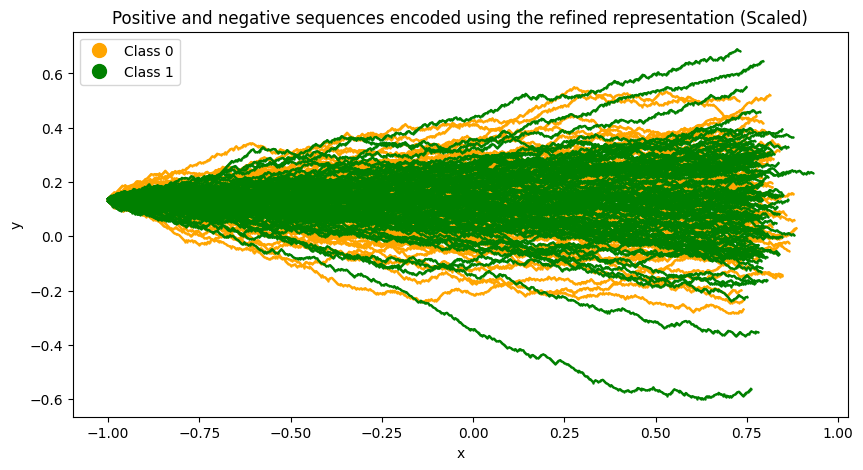

In [28]:
df_refined = df.copy()
df_refined["sequences"] = scaled_refined_repr
plot_sequences(
    df_refined.groupby("classes", group_keys=False).apply(
        lambda x: x.sample(100, random_state=312)
    ),
    "Positive and negative sequences encoded using the refined representation (Scaled)",
)

In [29]:
del tensor_refined
del refined_repr
del scaled_refined_repr
del df_refined

## Huffman Representation

- Apply transformation function
- Scale
- Pad to length
- Restructure as a tensor

In [30]:
huffman_repr = df["sequences"].map(
    get_transformation_function(DnaRepresentation.huffman)
)

scaled_huffman_repr = min_max_scale_globally(huffman_repr.to_numpy())

In [31]:
scaled_huffman_repr.map(len).nunique()

107

In [32]:
scaled_huffman_repr.map(len).value_counts()[:5]

1000    10186
998       167
994       161
996       156
999       152
Name: count, dtype: int64

In [33]:
padded_scaled_huffman_repr = scaled_huffman_repr.map(lambda x: pad_array(x, 1000))

In [34]:
padded_scaled_huffman_repr.map(len).nunique()

1

In [35]:
tensor_huffman: Tensor = torch.stack(
    tuple(
        padded_scaled_huffman_repr.map(
            lambda x: torch.tensor(x, requires_grad=False, dtype=torch.float32)
        )
    )
)

In [36]:
tensor_huffman.shape

torch.Size([14599, 1000, 2])

In [37]:
torch.save(tensor_huffman, "../../data/classification/tensor_huffman.pt")

/tmp/ipykernel_10834/4270535925.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_huffman.groupby("classes", group_keys=False).apply(


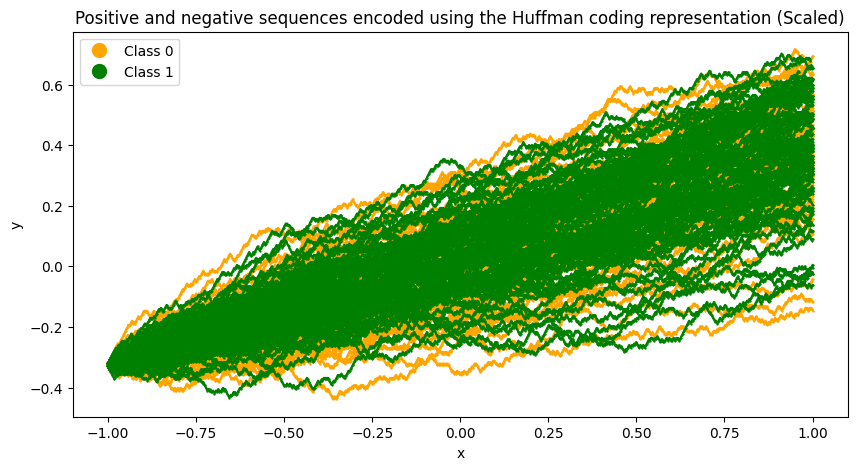

In [38]:
df_huffman = df.copy()
df_huffman["sequences"] = padded_scaled_huffman_repr
plot_sequences(
    df_huffman.groupby("classes", group_keys=False).apply(
        lambda x: x.sample(100, random_state=312)
    ),
    "Positive and negative sequences encoded using the Huffman coding representation (Scaled)",
)

In [39]:
del tensor_huffman
del huffman_repr
del scaled_huffman_repr
del padded_scaled_huffman_repr
del df_huffman

## Grayscale Representation

- Apply transformation function
- Restructure as a tensor

In [40]:
grayscale_repr = df["sequences"].map(
    get_transformation_function(DnaRepresentation.grayscale)
)

In [41]:
grayscale_repr.shape

(14599,)

In [42]:
tensor_grayscale: Tensor = torch.stack(
    tuple(
        grayscale_repr.map(
            lambda x: torch.tensor(x, requires_grad=False, dtype=torch.float32)
        )
    )
)

In [43]:
tensor_grayscale.shape

torch.Size([14599, 500])

In [44]:
torch.save(tensor_grayscale, "../../data/classification/tensor_grayscale.pt")

In [45]:
positive_example = df.query("classes == 1").iloc[0, 0]
negative_example = df.query("classes == 0").iloc[0, 0]

<Axes: >

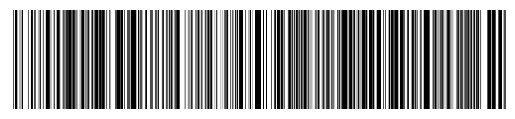

In [46]:
SequenceRepresentationFactory.create(
    positive_example, NucleotideMappingMethod.IMAGE_GRAYSCALE
).plot_representation()

<Axes: >

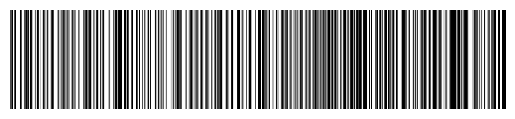

In [47]:
SequenceRepresentationFactory.create(
    negative_example, NucleotideMappingMethod.IMAGE_GRAYSCALE
).plot_representation()

# Classes

In [49]:
df["classes"]

0        1
1        1
2        0
3        0
4        0
        ..
14594    0
14595    1
14596    1
14597    1
14598    1
Name: classes, Length: 14599, dtype: int64

In [51]:
tensor_classes = torch.stack(
    tuple(
        df["classes"].map(
            lambda x: torch.tensor(x, requires_grad=False, dtype=torch.float32)
        )
    )
)

In [52]:
torch.save(tensor_classes, "../../data/classification/tensor_classes.pt")

In [54]:
pathlib.Path("a" / "b")

TypeError: unsupported operand type(s) for /: 'str' and 'str'